In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
#from keras.layers.preprocessing import preprocessing_utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install qutip
import qutip as qt
qt.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 63.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


'4.7.3'

In [4]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems
import data_gen

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models/test')
import test_fusion

In [5]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

# Generate noisy data

In [6]:
def gen_noise_free(all_params, mint, maxt, deltat, stride, start_meas=0, meas_op=[2,2], input_params=[3], init_ops=[2,2], params=None):
    if params is None:
      omega = 1.395
      kappa = 0.83156
      eta = 0.1469
      gamma_s = 0.0
      eps = 0.1
      params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

    if len(all_params.shape) == 1:
      all_params = all_params[:,tf.newaxis]

    all_params = tf.repeat(all_params, repeats=10, axis=0)
    num_traj = all_params.shape[0]
    print('num_traj',num_traj)
    for ii in range(params.shape[0]):
      if ii in input_params:
        param_idx = input_params.index(ii)
        param_inputs = all_params[:,param_idx:param_idx+1]
      else:
        param_inputs = params[ii]*np.ones_like(all_params[:,:1])

      if ii == 0:
        traj_inputs = param_inputs
      else:
        traj_inputs = tf.concat([traj_inputs, param_inputs], axis=1)

    meas_op0 = tf.one_hot([meas_op[0]], depth=3)*tf.ones([num_traj,3], tf.float32)
    meas_op1 = tf.one_hot([meas_op[1]], depth=3)*tf.ones([num_traj,3], tf.float32)
    traj_inputs = tf.concat([tf.cast(traj_inputs, tf.float32), meas_op0, meas_op1], axis=1)

    all_ops = sde_systems.paulis()
    rho0 = sde_systems.get_init_rho(all_ops[init_ops[0]], all_ops[init_ops[1]], 0, 0)[tf.newaxis,...]
    pauli_names = ['X', 'Y', 'Z']
    print(f'Initial state: {pauli_names[init_ops[0]]}{pauli_names[init_ops[1]]}00')
    print('params:', params)

    rhovec, ivec, _, _ = fusion.run_model_2d(rho0, traj_inputs, num_traj, mint=mint, maxt=maxt, deltat=deltat, sim_noise=True, start_meas=start_meas)
    probs = sde_systems.get_2d_probs(rhovec)
    probs = tf.math.real(probs)

    return ivec, probs, rhovec

In [7]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 0.83156
eta = 0.1469
gamma_s = 0.1
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [8]:
init_ops = [2,2]
for meas_idx in range(2,3,1):
  meas_op = [meas_idx,meas_idx]
  print('meas_op:', meas_op)
  meas_voltage, meas_all_probs, meas_rhovec = gen_noise_free(all_params, mint, maxt, deltat, stride, meas_op=meas_op, input_params=input_params, init_ops=init_ops, params=params)
  meas_voltage = tf.concat([meas_voltage, float(meas_idx)*tf.ones_like(meas_voltage[:,:,:1]), float(meas_idx)*tf.ones_like(meas_voltage[:,:,:1])], axis=2)

  if meas_idx == 2:
    nvoltage = meas_voltage[...,tf.newaxis]
    nall_probs = meas_all_probs[...,tf.newaxis]
    nrhovec = meas_rhovec[...,tf.newaxis]
  else:
    nvoltage = tf.concat([nvoltage, meas_voltage[...,tf.newaxis]], axis=-1)
    nall_probs = tf.concat([nall_probs, meas_all_probs[...,tf.newaxis]], axis=-1)
    nrhovec = tf.concat([nrhovec, meas_rhovec[...,tf.newaxis]], axis=-1)

  print(nvoltage.shape)
  print(nall_probs.shape)
  print(nrhovec.shape)

meas_op: [2, 2]
num_traj 400
Initial state: ZZ00
params: [1.395   1.66312 0.1469  0.1     0.1    ]
Start rho 2
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625
l t =  1.71875
l t =  1.875
l t =  2.03125
l t =  2.1875
l t =  2.34375
l t =  2.5
l t =  2.65625
l t =  2.8125
l t =  2.96875
l t =  3.125
l t =  3.28125
l t =  3.4375
l t =  3.59375
l t =  3.75
l t =  3.90625
Rho done
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625
l t =  1.71875
l t =  1.875
l t =  2.03125
l t =  2.1875
l t =  2.34375
l t =  2.5
l t =  2.65625
l t =  2.8125
l t =  2.96875
l t =  3.125
l t =  3.28125
l t =  3.4375
l t =  3.59375
l t =  3.75
l t =  3.90625
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


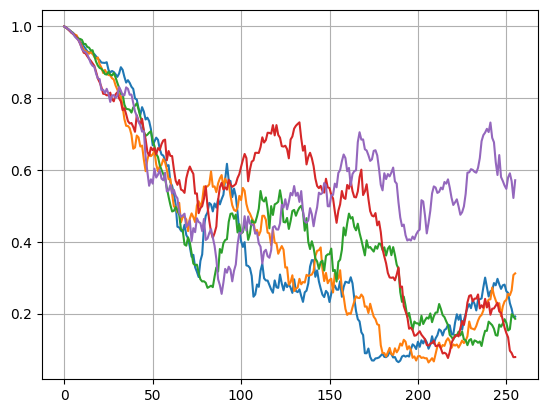

In [9]:
for idx in range(0,400,80):
  #plt.plot(nvoltage[idx,:,0,0])
  #plt.plot(nall_probs[idx,:,4,0])
  plt.plot(nrhovec[idx,:,0,0,0])
plt.grid();

In [10]:
# Validate density operators
all_rhovec = tf.reshape(tf.transpose(nrhovec, perm=[0,1,4,2,3]), [-1,4,4])
assert(test_fusion.validate_density(all_rhovec))

Max trace abs error: tf.Tensor(2.6645352591003757e-15, shape=(), dtype=float64)
Max rho - rho* F-norm: tf.Tensor(0.0, shape=(), dtype=float64)
Max imag: tf.Tensor(2.213361458516756e-16, shape=(), dtype=float64)
Min eval: tf.Tensor(0.0, shape=(), dtype=float64)
Evals checked: (102400, 4)
Pass: True


In [11]:
print(tf.reduce_min(nall_probs).numpy(), ",", tf.reduce_max(nall_probs).numpy())

0.0 , 1.0


# Generate noise free data

In [12]:
mint = 0
maxt = 4.0
deltat = 2**(-6)
tvec = np.arange(mint,maxt,deltat)

stride = 64

epsilons = np.arange(0.0, 2.0, 0.05)
all_params = epsilons[:,tf.newaxis]
input_params=[4]

omega = 1.395
kappa = 0.83156
eta = 0.1469
gamma_s = 0.1
eps = 0.1
params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)

In [13]:
init_ops = [2,2]
for meas_idx in range(3):
  meas_op = [meas_idx,meas_idx]
  print('meas_op:', meas_op)
  meas_voltage, meas_all_probs, meas_rhovec = data_gen.gen_noise_free(all_params, mint, maxt, deltat, stride, meas_op=meas_op, input_params=input_params, init_ops=init_ops, params=params)
  meas_voltage = tf.concat([meas_voltage, float(meas_idx)*tf.ones_like(meas_voltage[:,:,:1]), float(meas_idx)*tf.ones_like(meas_voltage[:,:,:1])], axis=2)

  if meas_idx == 0:
    voltage = meas_voltage[...,tf.newaxis]
    all_probs = meas_all_probs[...,tf.newaxis]
    rhovec = meas_rhovec[...,tf.newaxis]
  else:
    voltage = tf.concat([voltage, meas_voltage[...,tf.newaxis]], axis=-1)
    all_probs = tf.concat([all_probs, meas_all_probs[...,tf.newaxis]], axis=-1)
    rhovec = tf.concat([rhovec, meas_rhovec[...,tf.newaxis]], axis=-1)

  print(voltage.shape)
  print(all_probs.shape)
  print(rhovec.shape)

meas_op: [0, 0]
Initial state: ZZ00
params: [1.395   1.66312 0.1469  0.1     0.1    ]
Start rho 2
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625
l t =  1.71875
l t =  1.875
l t =  2.03125
l t =  2.1875
l t =  2.34375
l t =  2.5
l t =  2.65625
l t =  2.8125
l t =  2.96875
l t =  3.125
l t =  3.28125
l t =  3.4375
l t =  3.59375
l t =  3.75
l t =  3.90625
Rho done
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625
l t =  1.71875
l t =  1.875
l t =  2.03125
l t =  2.1875
l t =  2.34375
l t =  2.5
l t =  2.65625
l t =  2.8125
l t =  2.96875
l t =  3.125
l t =  3.28125
l t =  3.4375
l t =  3.59375
l t =  3.75
l t =  3.90625
l t =  0.0
l t =  0.15625
l t =  0.3125
l t =  0.46875
l t =  0.625
l t =  0.78125
l t =  0.9375
l t =  1.09375
l t =  1.25
l t =  1.40625
l t =  1.5625
l t =  1.718

In [14]:
# Validate density operators
all_rhovec = tf.reshape(tf.transpose(rhovec, perm=[0,1,4,2,3]), [-1,4,4])
assert(test_fusion.validate_density(all_rhovec))

Max trace abs error: tf.Tensor(1.3322676295501878e-15, shape=(), dtype=float64)
Max rho - rho* F-norm: tf.Tensor(0.0, shape=(), dtype=float64)
Max imag: tf.Tensor(9.545812358479796e-17, shape=(), dtype=float64)
Min eval: tf.Tensor(0.0, shape=(), dtype=float64)
Evals checked: (30720, 4)
Pass: True


## Check self-consistency between probabilities, voltages, and the Liouvillian

## Validate the simulated data against QuTiP

In [15]:
#import qutip.testing
#qutip.testing.run()

In [16]:
psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

In [17]:
epsidx = 20
eps = epsilons[epsidx]
sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
sx1 = qt.tensor(qt.identity(2), qt.sigmax())
sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
sy1 = qt.tensor(qt.identity(2), qt.sigmay())
sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
sm0 = qt.tensor(qt.sigmam(), qt.identity(2))
sm1 = qt.tensor(qt.identity(2), qt.sigmam())

sxx = qt.tensor(qt.sigmax(), qt.sigmax())
sxy = qt.tensor(qt.sigmax(), qt.sigmay())
sxz = qt.tensor(qt.sigmax(), qt.sigmaz())

syx = qt.tensor(qt.sigmay(), qt.sigmax())
syy = qt.tensor(qt.sigmay(), qt.sigmay())
syz = qt.tensor(qt.sigmay(), qt.sigmaz())

szx = qt.tensor(qt.sigmaz(), qt.sigmax())
szy = qt.tensor(qt.sigmaz(), qt.sigmay())
szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

H = 0.5*omega*(sx0 + sx1) + eps*szz

In [18]:
psi0

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [19]:
result = qt.mesolve(H, psi0, tvec, [np.sqrt(kappa) * sz0, np.sqrt(kappa) * sz1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], [])

In [26]:
for timeidx in range(rhovec.shape[1]):
  print(tf.reduce_max(tf.abs(result.states[timeidx] - rhovec[epsidx,timeidx,:,:,2])).numpy())

0.0
0.0002469122768969825
0.0004893096685721474
0.0007269850632675226
0.0009596246622980094
0.0011868333653756757
0.0014081564661451208
0.0016230978182756694
0.0018311466701947242
0.002031782697443687
0.0022244932853870084
0.0024087806616002886
0.002584174667268486
0.0027502451910678635
0.0029066029094054657
0.003052898301853408
0.0031888356077809346
0.003314176840997875
0.0034287345163495383
0.003532377324061527
0.003625030961868437
0.0037066794089492287
0.003777363618687928
0.003837179251192532
0.0038862711846261214
0.003924840323747176
0.003953143051543814
0.003971476455430276
0.003980182833619538
0.003979652489139669
0.003970317575150718
0.003952643205715668
0.003927134295793654
0.003894327678593969
0.0038547869676013456
0.0038091124369485003
0.003757924564422049
0.0037018563114976587
0.003641573132171782
0.0035777506300366207
0.0035110671502957174
0.003442223879917808
0.0033719197227233284
0.003300843187029911
0.0032296904957163277
0.003159140024419479
0.0030898437901597
0.0031575

In [27]:
result = qt.mesolve(H, psi0, tvec, [np.sqrt(kappa) * sz0, np.sqrt(kappa) * sz1, np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], [sx0, sx1, sy0, sy1, sz0, sz1, sxx, sxy, sxz, syx, syy, syz, szx, szy, szz])

E[O] = p - (1-p) = 2p - 1 \\
p = 0.5*(E[O] + 1)

In [28]:
result.expect[0].dtype

dtype('float64')

In [29]:
def all_probs_to_exp(all_probs):
  # First order expectations
  for prob_idx in range(3):
    for qidx in range(2):
      single_exp = all_probs[:,2*prob_idx+qidx] - (1.0 - all_probs[:,2*prob_idx+qidx])
      if qidx == 0 and prob_idx == 0:
        all_exp = tf.constant(single_exp)[:,tf.newaxis]
      else:
        all_exp = tf.concat([all_exp, tf.constant(single_exp)[:,tf.newaxis]], axis=1)

  # Second order expectations
  expidx = 0
  for rowidx in range(3):
    for colidx in range(3):
      prob_idx = 6+expidx*4
      eoo = all_probs[:,prob_idx] - all_probs[:,prob_idx+1] - all_probs[:,prob_idx+2] + all_probs[:,prob_idx+3]
      all_exp = tf.concat([all_exp, eoo[:,tf.newaxis]], axis=1)
      expidx += 1

  return all_exp

In [30]:
all_exp = all_probs_to_exp(all_probs[epsidx,:,:,2])
all_exp.shape

TensorShape([256, 15])

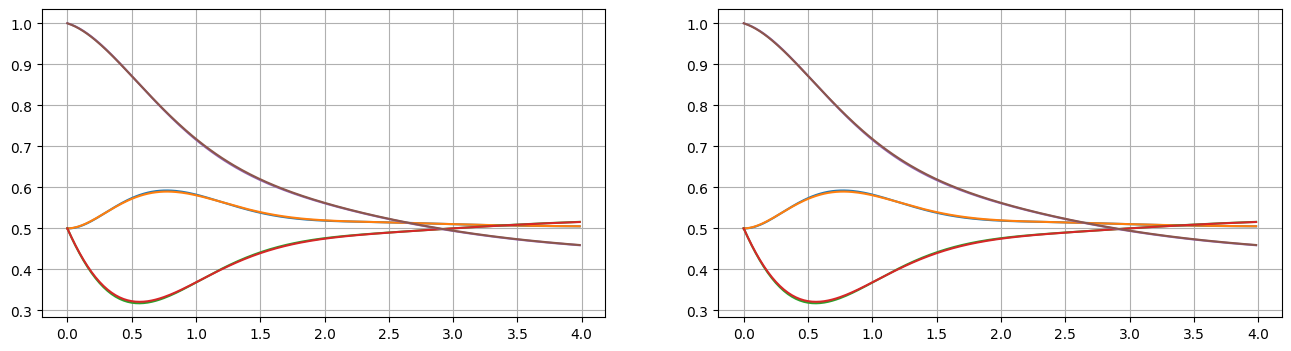

In [31]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  for prob_idx in range(3):
    plt.plot(tvec, all_probs[epsidx,:,2*prob_idx+qidx,2])
    plt.plot(tvec, 0.5*(result.expect[2*prob_idx+qidx] + 1.0))
  plt.grid();

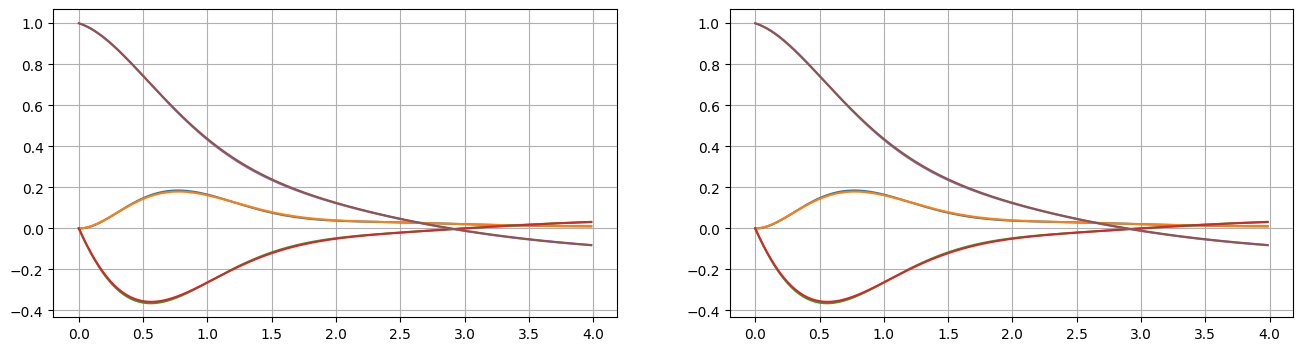

In [32]:
epsidx = 20
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  for prob_idx in range(3):
    plt.plot(tvec, all_exp[:,2*prob_idx+qidx])
    plt.plot(tvec, result.expect[2*prob_idx+qidx])
  plt.grid();

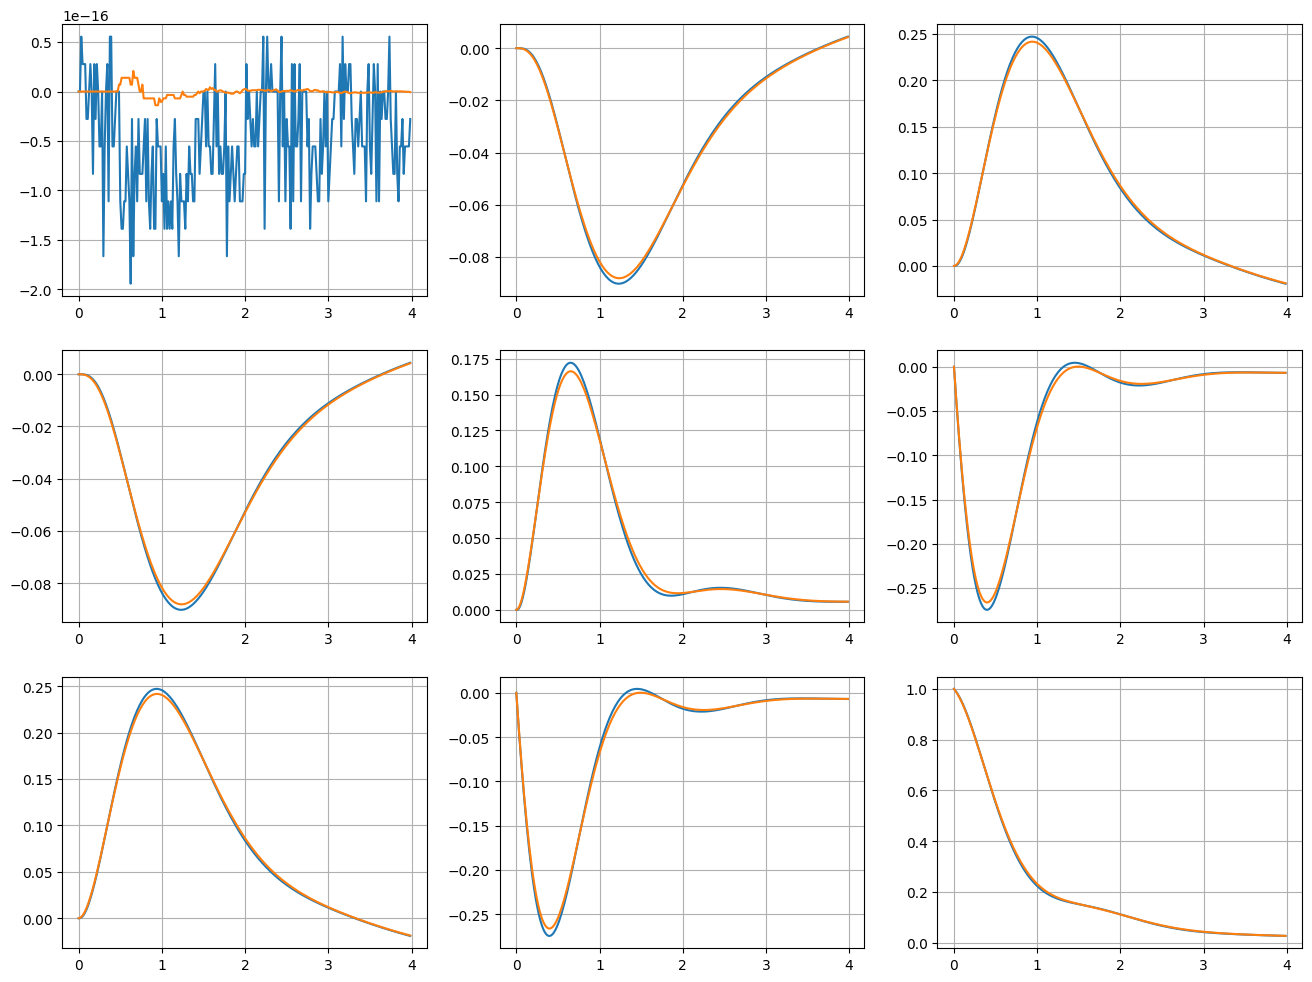

In [33]:
plt.figure(figsize=(16,12))
pltidx = 0
for rowidx in range(3):
  for colidx in range(3):
    plt.subplot(3,3,pltidx+1)
    prob_idx = 6+pltidx*4
    #eoo = all_probs[epsidx,:,prob_idx,2] - all_probs[epsidx,:,prob_idx+1,2] - all_probs[epsidx,:,prob_idx+2,2] + all_probs[epsidx,:,prob_idx+3,2]
    #plt.plot(tvec, eoo)
    plt.plot(tvec, all_exp[:,6+pltidx])
    plt.plot(tvec, result.expect[6+pltidx])
    plt.grid();
    pltidx += 1

In [34]:
msetol = 3e-5
mabstol = 2e-2
state_msetol = 5e-7
meas0 = [sx0, sy0, sz0]
meas1 = [sx1, sy1, sz1]
global_maxmse = 0.0
global_maxmabs = 0.0
max_state_mse = 0.0
for measidx in range(3):
  for epsidx in range(all_probs.shape[0]):
    print(measidx, epsidx)
    eps = epsilons[epsidx]
    all_exp = all_probs_to_exp(all_probs[epsidx,:,:,measidx])

    H = 0.5*omega*(sx0 + sx1) + eps*szz
    result = qt.mesolve(H, psi0, tvec, [np.sqrt(kappa) * meas0[measidx], np.sqrt(kappa) * meas1[measidx], np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], [sx0, sx1, sy0, sy1, sz0, sz1, sxx, sxy, sxz, syx, syy, syz, szx, szy, szz])

    maxmse = 0.0
    maxmabs = 0.0
    for expidx in range(len(result.expect)):
      mse = tf.reduce_mean(tf.square(all_exp[:,expidx] - result.expect[expidx])).numpy()
      mabs = tf.reduce_max(tf.abs(all_exp[:,expidx] - result.expect[expidx])).numpy()
      assert(mse < msetol)
      assert(mabs < mabstol)
      if mse > maxmse:
        maxmse = mse
      if mabs > maxmabs:
        maxmabs = mabs
    print('Largest MSE:', maxmse)
    print('Largest max abs:', maxmabs)
    if maxmse > global_maxmse:
      global_maxmse = maxmse
    if maxmabs > global_maxmabs:
      global_maxmabs = maxmabs

    # Compare states
    result = qt.mesolve(H, psi0, tvec, [np.sqrt(kappa) * meas0[measidx], np.sqrt(kappa) * meas1[measidx], np.sqrt(gamma_s)*sm0, np.sqrt(gamma_s)*sm1], [])
    for timeidx in range(rhovec.shape[1]):
      diff = result.states[timeidx] - rhovec[epsidx,timeidx,:,:,measidx]
      if timeidx == 0:
        state_diff = diff[tf.newaxis,...]
      else:
        state_diff = tf.concat([state_diff,diff[tf.newaxis,...]], axis=0)
    state_mse = tf.reduce_mean(tf.square(tf.abs(diff))).numpy()
    assert(state_mse < state_msetol)
    print('State MSE:', state_mse)
    if state_mse > max_state_mse:
      max_state_mse = state_mse
print('Global largest MSE:', global_maxmse)
print('Global largest max abs:', global_maxmabs)
print('Largest state MSE:', max_state_mse)
print('PASS')

0 0
Largest MSE: 2.0352786372261403e-05
Largest max abs: 0.013534439011079952
State MSE: 7.678863821967629e-10
0 1
Largest MSE: 2.0353834087421418e-05
Largest max abs: 0.013535285368658723
State MSE: 7.669745720139104e-10
0 2
Largest MSE: 2.035695475092994e-05
Largest max abs: 0.013537845701450502
State MSE: 7.642016386933863e-10
0 3
Largest MSE: 2.036212584708442e-05
Largest max abs: 0.01354210731762992
State MSE: 7.598171242551793e-10
0 4
Largest MSE: 2.0369261932045065e-05
Largest max abs: 0.013548061830312846
State MSE: 7.54133088468027e-10
0 5
Largest MSE: 2.0378261079187512e-05
Largest max abs: 0.013555697493303154
State MSE: 7.477366947266864e-10
0 6
Largest MSE: 2.0388994452216783e-05
Largest max abs: 0.013564999206799544
State MSE: 7.417076953052566e-10
0 7
Largest MSE: 2.0401311027062988e-05
Largest max abs: 0.0135759486570394
State MSE: 7.379578442957536e-10
0 8
Largest MSE: 2.0415037056897143e-05
Largest max abs: 0.013588524049223893
State MSE: 7.394432189967512e-10
0 9
Lar

# Train the Model

In [35]:
all_x_mean = voltage[:,tf.newaxis,...]
all_y = tf.math.real(voltage[:,tf.newaxis,...])

In [36]:
# Split the voltages
train_frac = 0.5
train_x, valid_x, train_y, valid_y = fusion.split_data(all_x_mean.numpy(), all_y.numpy(), train_frac)
_, _, train_probs, valid_probs = fusion.split_data(all_x_mean.numpy(), all_probs.numpy(), train_frac)
_, _, train_rho, valid_rho = fusion.split_data(all_x_mean.numpy(), rhovec.numpy(), train_frac)
_, _, train_params, valid_params = fusion.split_data(all_x_mean.numpy(), epsilons, train_frac)

print(train_x.shape)
print(train_y.shape)
print(train_probs.shape)
print(train_rho.shape)
print(train_params.shape)

(20, 1, 256, 4, 3)
(20, 1, 256, 4, 3)
(20, 256, 42, 3)
(20, 256, 4, 4, 3)
(20,)


In [37]:
train_x = tf.reshape(train_x, [-1, train_x.shape[2], train_x.shape[3], train_x.shape[4]])
train_y = tf.reshape(train_y, [-1, train_y.shape[2], train_y.shape[3], train_y.shape[4]])
valid_x = tf.reshape(valid_x, [-1, valid_x.shape[2], valid_x.shape[3], valid_x.shape[4]])
valid_y = tf.reshape(valid_y, [-1, valid_y.shape[2], valid_y.shape[3], valid_y.shape[4]])
train_params = tf.repeat(train_params, all_x_mean.shape[1], axis=0)
valid_params = tf.repeat(valid_params, all_x_mean.shape[1], axis=0)
#train_probs = tf.repeat(tf.transpose(train_probs, perm=[0,1,3,2]), all_x_mean.shape[1], axis=0)
#valid_probs = tf.repeat(tf.transpose(valid_probs, perm=[0,1,3,2]), all_x_mean.shape[1], axis=0)

In [38]:
train_y = tf.concat([train_y[...,tf.newaxis], tf.ones_like(train_y[...,tf.newaxis])*train_params[:,tf.newaxis,tf.newaxis,tf.newaxis,tf.newaxis]], axis=-1)
valid_y = tf.concat([valid_y[...,tf.newaxis], tf.ones_like(valid_y[...,tf.newaxis])*valid_params[:,tf.newaxis,tf.newaxis,tf.newaxis,tf.newaxis]], axis=-1)

In [39]:
# Keep the real parts of the data only
train_x = np.real(train_x)
train_y = np.real(train_y)
valid_x = np.real(valid_x)
valid_y = np.real(valid_y)

print(train_x.shape)
print(train_y.shape)
print(train_params.shape)
print(valid_x.shape)
print(valid_y.shape)
print(valid_params.shape)

(20, 256, 4, 3)
(20, 256, 4, 3, 2)
(20,)
(20, 256, 4, 3)
(20, 256, 4, 3, 2)
(20,)


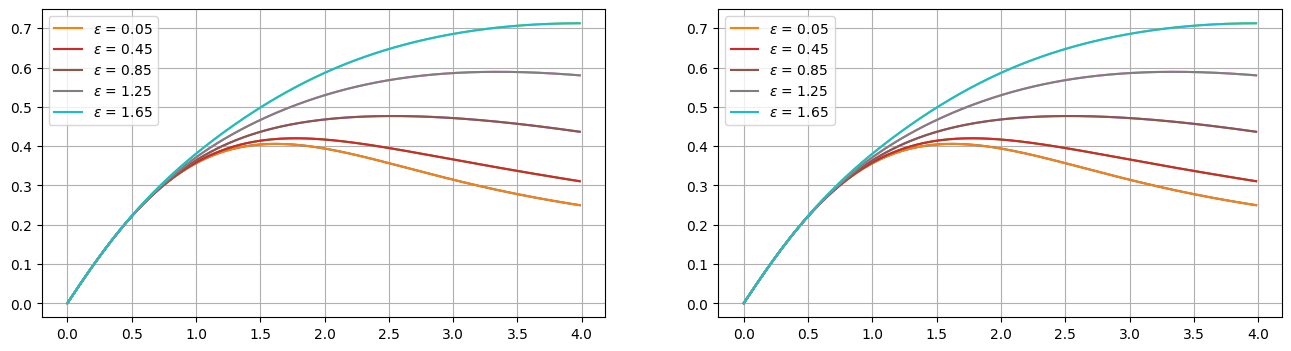

In [40]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  for idx in range(0,train_x.shape[0],int(train_x.shape[0]/5)):
    for idx2 in range(1):
      plt.plot(tvec, train_x[idx+idx2,:,qidx,2])
    plt.plot(tvec, train_y[idx,:,qidx,2,0], label=f'$\epsilon$ = {train_params[idx]:.3g}')
  plt.legend()
  plt.grid();

In [41]:
train_params

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])>

In [42]:
valid_params

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])>

In [43]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

In [44]:
# Build RNN model
#_, seq_len, num_features, num_meas, num_strong_probs = train_x.shape
_, seq_len, num_features, num_meas = train_x.shape
num_strong_probs = 0
num_features -= 2
conv_sizes = [32]
encoder_sizes = [100, 50]
enc_lstm_size = 32
dec_lstm_size = 10
avg_size = 20
num_traj = 1
start_meas = 0.0
comp_iq = True
project_rho = True
strong_probs = []
strong_probs_input = True
input_params = [4]
num_params = 1

max_val = 12
offset = 1

td_sizes = [32, 16]

# Starting with ZZ00 initial condition
sx, sy, sz = sde_systems.paulis()
rho0 = sde_systems.get_init_rho(sz, sz, 0, 0)

# Set the parameter values (with an omega error)
params = np.array([1.395,2.0*0.83156,0.1469,0.0,0.1], dtype=np.double)
#params = np.array([1.0,4.0*2.0*0.83156,0.1469,0.0,0.1], dtype=np.double)

model = flex.build_multimeas_rnn_model(seq_len, num_features, num_meas, avg_size, enc_lstm_size, dec_lstm_size, td_sizes, encoder_sizes, num_params,
                                       rho0, params, deltat, num_traj, start_meas, comp_iq=comp_iq, max_val=max_val, offset=offset,
                                       strong_probs=strong_probs, project_rho=project_rho, strong_probs_input=strong_probs_input,
                                       input_params=input_params)

model.summary()

l t =  Tensor("physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
l t =  Tensor("physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
Model: "multimeas_rnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 4, 3)]          0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 256, 2, 3)            0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 reshape (Reshape)           (None, 256, 6,

In [45]:
loss_func = fusion.fusion_mse_loss_voltage_xyz
metric_func = fusion.param_metric_volt_xyz
fusion.compile_model(model, loss_func, metrics=[metric_func])

In [46]:
model.trainable_weights

[<tf.Variable 'lstm_layer/lstm_cell/kernel:0' shape=(6, 128) dtype=float32, numpy=
 array([[ 1.31944463e-01, -2.75295377e-02,  1.89130679e-01,
          1.71293274e-01,  1.23915210e-01, -2.64500529e-02,
         -2.41207629e-02,  1.40989885e-01, -2.08782047e-01,
          1.86893061e-01, -1.28616050e-01,  1.92240015e-01,
          1.80504575e-01, -1.80630669e-01,  4.07445282e-02,
         -6.64727390e-03, -3.48744988e-02, -8.56378824e-02,
          1.55514613e-01,  1.70744166e-01, -1.36569321e-01,
          1.99045107e-01, -1.47049755e-01, -1.58422977e-01,
         -1.55735478e-01,  1.17911026e-01, -1.05755530e-01,
         -1.08848177e-01,  9.73512679e-02,  1.53292224e-01,
          1.13703758e-02, -7.69801736e-02, -2.01055706e-01,
          1.96791694e-01,  1.08203009e-01,  1.44082740e-01,
          7.53268600e-04, -1.29583538e-01, -7.63566047e-02,
         -5.30726612e-02,  1.15198642e-02, -2.65503526e-02,
         -2.96608657e-02,  1.87917754e-01, -1.07736103e-01,
          1.10925

In [47]:
for val in model.layers[-4].trainable_weights:
  print(val.name, tf.reduce_mean(val))

physical_layer/euler_flex_rnn_cell/lstm_cell/kernel:0 tf.Tensor(-6.3514517e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/recurrent_kernel:0 tf.Tensor(-1.7683466e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/bias:0 tf.Tensor(0.25, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/kernel:0 tf.Tensor(-3.0885607e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/recurrent_kernel:0 tf.Tensor(-2.693796e-08, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/bias:0 tf.Tensor(0.25, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/kernel:0 tf.Tensor(3.9184022e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/bias:0 tf.Tensor(0.0, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/kernel:0 tf.Tensor(-5.962413e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/bias:0 tf.Tensor(0.0, shape=(), 

In [48]:
model_out = model.predict(valid_x)
print('Initial validation loss: %.5f' % (loss_func(valid_y, model_out)))

l t =  Tensor("multimeas_rnn/physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
l t =  Tensor("multimeas_rnn/physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
1/1 [==============================] - 15s 15s/step
Initial validation loss: 0.01442


In [49]:
model_out.shape

(20, 256, 2, 3, 3)

In [50]:
trim_idx = 2
metric_func(valid_y[trim_idx:-trim_idx,...], model_out[trim_idx:-trim_idx,...])**2

<tf.Tensor: shape=(), dtype=float64, numpy=0.21517016948200424>

In [51]:
# Keras train
verbose_level = 1
mini_batch_size = 10
num_epochs = 100

# Set which layers are trainable
first_run = True
if first_run:
  model.get_layer('physical_layer').cell.set_return_density(False)
  train_decoder = True
  for layer in model.layers:
    #layer.trainable = not train_decoder
    layer.trainable = True
  model.layers[-4].trainable = train_decoder
  model.layers[-4].cell.trainable = train_decoder
  model.layers[-4].cell.flex.a_cell_real.trainable = train_decoder
  model.layers[-4].cell.flex.a_cell_imag.trainable = train_decoder
  model.layers[-4].cell.flex.b_cell_real.trainable = train_decoder
  model.layers[-4].cell.flex.b_cell_imag.trainable = train_decoder
  model.layers[-4].cell.flex.a_dense_real.trainable = train_decoder
  model.layers[-4].cell.flex.a_dense_imag.trainable = train_decoder
  model.layers[-4].cell.flex.b_dense_real.trainable = train_decoder
  model.layers[-4].cell.flex.b_dense_imag.trainable = train_decoder

  fusion.compile_model(model, loss_func, metrics=[metric_func])

  for val in model.layers[-4].trainable_weights:
    print(val.name, tf.reduce_mean(val))

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

physical_layer/euler_flex_rnn_cell/lstm_cell/kernel:0 tf.Tensor(-6.3514517e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/recurrent_kernel:0 tf.Tensor(-1.7683466e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/bias:0 tf.Tensor(0.25, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/kernel:0 tf.Tensor(-3.0885607e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/recurrent_kernel:0 tf.Tensor(-2.693796e-08, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/bias:0 tf.Tensor(0.25, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/kernel:0 tf.Tensor(3.9184022e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/bias:0 tf.Tensor(0.0, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/kernel:0 tf.Tensor(-5.962413e-07, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/bias:0 tf.Tensor(0.0, shape=(), 

l t =  Tensor("multimeas_rnn/physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
l t =  Tensor("multimeas_rnn/physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0


2/2 [==============================] - ETA: 0s - loss: 0.0129 - param_metric_volt_xyz: 0.5767 l t =  Tensor("multimeas_rnn/physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
l t =  Tensor("multimeas_rnn/physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
2/2 [==============================] - 62s 21s/step - loss: 0.0129 - param_metric_volt_xyz: 0.5767 - val_loss: 0.0108 - val_param_metric_volt_xyz: 0.5775 - lr: 0.0030
Epoch 2/100
2/2 [==============================] - 17s 10s/step - loss: 0.0095 - param_metric_volt_xyz: 0.5727 - val_loss: 0.0080 - val_param_metric_volt_xyz: 0.5765 - lr: 0.0030
Epoch 3/100
2/2 [==============================] - 18s 11s/step - loss: 0.0076 - param_metric_volt_xyz: 0.5763 - val_loss: 0.0066 - val_param_metric_volt_xyz: 0.5670 - lr: 0.0029
Epoch 4/100
2/2 [==============================] - 17s 10s/step - loss: 0.0065 - param_metric_volt_xyz: 0.5683 -

In [52]:
if first_run:
  pmetric = []
  vpmetric = []
  tloss = []
  vloss = []
pmetric += history.history['param_metric_volt_xyz']
vpmetric += history.history['val_param_metric_volt_xyz']
#pmetric += history.history['<lambda>']
#vpmetric += history.history['val_<lambda>']
tloss += history.history['loss']
vloss += history.history['val_loss']

In [53]:
# Reset LR and train again
verbose_level = 1
mini_batch_size = 10
num_epochs = 100

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/100
2/2 [==============================] - 17s 10s/step - loss: 9.1985e-06 - param_metric_volt_xyz: 0.0301 - val_loss: 1.2627e-05 - val_param_metric_volt_xyz: 0.0436 - lr: 0.0030
Epoch 2/100
2/2 [==============================] - 17s 10s/step - loss: 1.1277e-05 - param_metric_volt_xyz: 0.0330 - val_loss: 8.5542e-06 - val_param_metric_volt_xyz: 0.0335 - lr: 0.0030
Epoch 3/100
2/2 [==============================] - 17s 10s/step - loss: 8.0185e-06 - param_metric_volt_xyz: 0.0332 - val_loss: 1.3213e-05 - val_param_metric_volt_xyz: 0.0192 - lr: 0.0029
Epoch 4/100
2/2 [==============================] - 17s 10s/step - loss: 9.6651e-06 - param_metric_volt_xyz: 0.0267 - val_loss: 1.2579e-05 - val_param_metric_volt_xyz: 0.0418 - lr: 0.0029
Epoch 5/100
2/2 [==============================] - 17s 10s/step - loss: 1.4031e-05 - param_metric_volt_xyz: 0.0279 - val_loss: 1.1704e-05 - val_param_metric_volt_xyz: 0.0413 - lr: 0.0029
Epoch 6/100
2/2 [==============================] - 17s 11s/step -

In [54]:
pmetric += history.history['param_metric_volt_xyz']
vpmetric += history.history['val_param_metric_volt_xyz']
tloss += history.history['loss']
vloss += history.history['val_loss']

In [55]:
model.trainable_weights

[<tf.Variable 'lstm_layer/lstm_cell/kernel:0' shape=(6, 128) dtype=float32, numpy=
 array([[ 1.12751134e-01, -5.91160245e-02,  1.63357779e-01,
          1.44630939e-01,  1.08276218e-01, -3.76980565e-02,
         -6.05482608e-02,  1.21594317e-01, -2.50673175e-01,
          1.49141908e-01, -1.15472831e-01,  1.94499522e-01,
          1.91712737e-01, -1.85568914e-01,  4.69773263e-02,
         -3.54236215e-02, -4.94891442e-02, -1.25244275e-01,
          1.50429636e-01,  1.68850616e-01, -1.73138589e-01,
          1.80704743e-01, -1.65063560e-01, -1.69499964e-01,
         -1.67181775e-01,  1.04908697e-01, -1.11356959e-01,
         -1.49480239e-01,  8.02958682e-02,  1.62399590e-01,
          1.17724752e-02, -9.02211294e-02, -2.20597580e-01,
          1.63411587e-01,  8.03782567e-02,  1.17815532e-01,
         -1.54265156e-02, -1.41362891e-01, -1.14463411e-01,
         -7.41364211e-02, -3.33836935e-02, -6.49796873e-02,
         -1.53555088e-02,  1.90319508e-01, -9.43814591e-02,
          1.05230

In [56]:
for val in model.layers[-4].trainable_weights:
  print(val.name, tf.reduce_mean(val))

physical_layer/euler_flex_rnn_cell/lstm_cell/kernel:0 tf.Tensor(-0.010052744, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/recurrent_kernel:0 tf.Tensor(-0.0032491582, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell/bias:0 tf.Tensor(0.23570827, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/kernel:0 tf.Tensor(-0.00248998, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/recurrent_kernel:0 tf.Tensor(-0.00010126742, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/lstm_cell_1/bias:0 tf.Tensor(0.24394576, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/kernel:0 tf.Tensor(3.3768993e-05, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_4/bias:0 tf.Tensor(0.008978719, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/kernel:0 tf.Tensor(-0.00074141176, shape=(), dtype=float32)
physical_layer/euler_flex_rnn_cell/dense_5/bias:0 tf.Tensor

## Analyze Results

l t =  Tensor("multimeas_rnn/physical_layer/euler_flex_rnn_cell/strided_slice_8:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
l t =  Tensor("multimeas_rnn/physical_layer/while/euler_flex_rnn_cell/strided_slice_12:0", shape=(), dtype=float32)
l t =  0.0
l t =  0.0
1/1 [==============================] - 4s 4s/step


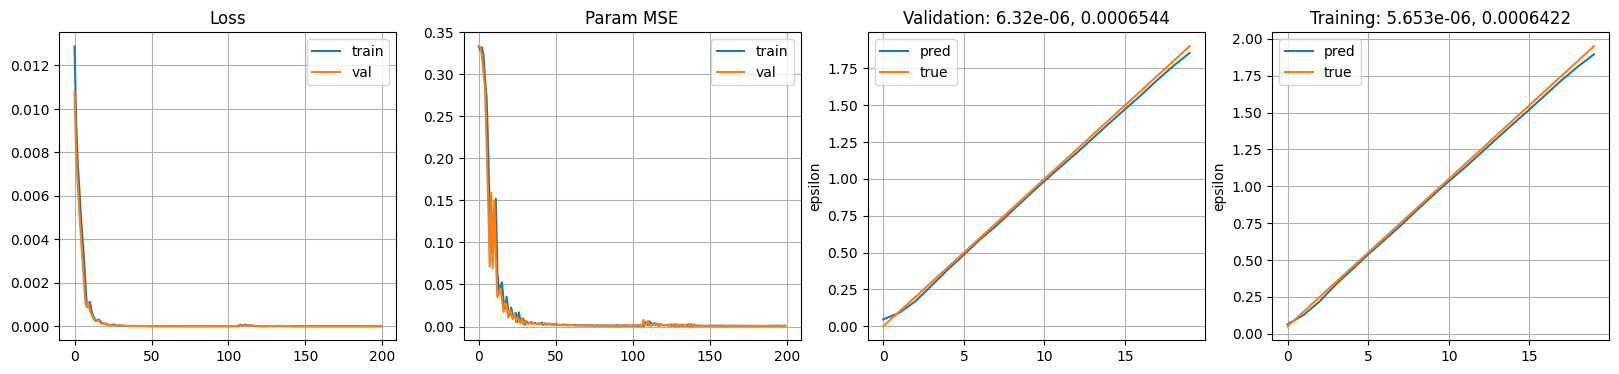

In [57]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,4,1)

plt.plot(tloss, label='train')
plt.plot(vloss, label='val')
plt.legend()
plt.title('Loss')
plt.grid();

plt.subplot(1,4,2)

plt.plot(np.array(pmetric)**2, label='train')
plt.plot(np.array(vpmetric)**2, label='val')
plt.legend()
plt.title('Param MSE')
plt.grid();

plt.subplot(1,4,3)
model_out = model.predict(valid_x)
plt.plot(model_out[:,-1,0,-1,0] + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4g, %.4g' % (loss_func(valid_y, model_out).numpy(), metric_func(valid_y, model_out).numpy()**2))
plt.ylabel('epsilon');

plt.subplot(1,4,4)
model_out = model.predict(train_x)
plt.plot(model_out[:,-1,0,-1,0] + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4g, %.4g' % (loss_func(train_y, model_out).numpy(), metric_func(train_y, model_out).numpy()**2))
plt.ylabel('epsilon');

In [58]:
model_out = model.predict(valid_x)
print('Final validation loss: %.3g' % (loss_func(valid_y, model_out)))

1/1 [==============================] - 5s 5s/step
Final validation loss: 6.32e-06


In [59]:
trim_idx = 2
print('Trimmed epsilon MSE: %.3g' % tf.reduce_mean(tf.square(model_out[trim_idx:-trim_idx,-1,0,-1,0] - valid_params[trim_idx:-trim_idx])))

Trimmed epsilon MSE: 0.000476


## Validate and test density history

In [60]:
layer_name = 'physical_layer'
model.get_layer(layer_name).cell.set_return_density(True)
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                          outputs=model.get_layer(layer_name).output)
intermediate_layer_model.compile()
intermediate_layer_model.summary()
intermediate_output = intermediate_layer_model.predict(valid_x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 4, 3)]          0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 256, 2, 3)            0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 reshape (Reshape)           (None, 256, 6, 1)            0         ['tf.__operators__.getitem_2[0
                                                                    ][0]']                        
                                                                                              

In [61]:
intermediate_output.shape

(60, 256, 4, 4)

In [62]:
# Validate density operators
model_all_rho = tf.reshape(intermediate_output, [-1,4,4])
assert(test_fusion.validate_density(model_all_rho))

Max trace abs error: tf.Tensor(2.6645352591003757e-15, shape=(), dtype=float64)
Max rho - rho* F-norm: tf.Tensor(0.0, shape=(), dtype=float64)
Max imag: tf.Tensor(9.713586574622195e-17, shape=(), dtype=float64)
Min eval: tf.Tensor(0.000365104459357677, shape=(), dtype=float64)
Evals checked: (15360, 4)
Pass: True


In [63]:
model_valid_rho = tf.transpose(tf.reshape(intermediate_output, [valid_rho.shape[0],-1,valid_rho.shape[1],4,4]), perm=[0,2,3,4,1])

In [64]:
model_valid_rho.shape

TensorShape([20, 256, 4, 4, 3])

In [65]:
def compare_rho(rho1, rho2):
  print('Max F-Norm:',tf.reduce_max(tf.sqrt(tf.reduce_sum(tf.square(tf.abs(rho1[:,:-1,...] - rho2[:,1:,...])), axis=[2,3]))).numpy())
  print('Mean F-Norm:',tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.abs(rho1[:,:-1,...] - rho2[:,1:,...])), axis=[2,3]))).numpy())
  print('Mean F-Norm^2:',tf.reduce_mean(tf.reduce_sum(tf.square(tf.abs(rho1[:,:-1,...] - rho2[:,1:,...])), axis=[2,3])).numpy())
  print('MSE:', tf.reduce_mean(tf.square(tf.abs(rho1[:,:-1,...] - rho2[:,1:,...]))).numpy())

In [66]:
compare_rho(model_valid_rho, valid_rho)

Max F-Norm: 0.061536304273904184
Mean F-Norm: 0.02702661783362756
Mean F-Norm^2: 0.0008817516887553514
MSE: 5.510948054720947e-05


In [67]:
model_probs = sde_systems.get_2d_probs(model_valid_rho[...,0])
model_probs.shape

TensorShape([20, 256, 42])

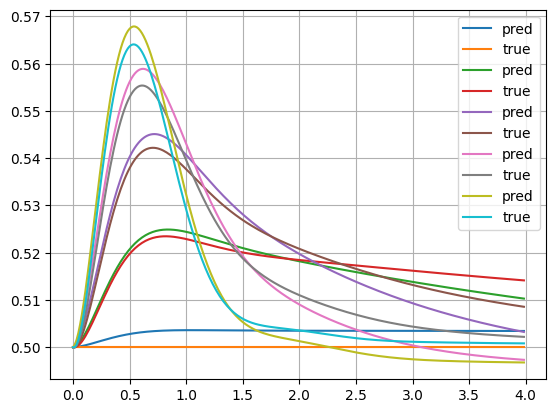

In [68]:
for idx in range(0,valid_probs.shape[0],int(valid_probs.shape[0]/5)):
  prob_idx = 0
  plt.plot(tvec, model_probs[idx,:,prob_idx], label='pred')
  plt.plot(tvec, valid_probs[idx,:,prob_idx,0], label='true')
  plt.legend()
  plt.grid();